In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2g}'.format)

In [2]:
from sklearn_utils.utils import SkUtilsIO

X, y = SkUtilsIO('../outputs/bc_sampling_hist.json', gz=True).from_json()

In [3]:
from sklearn.pipeline import Pipeline
from metabolitics.preprocessing import MetaboliticsPipeline
from metabolitics_sampling import SamplingDiffTransformer


pipe_f = Pipeline([
    ('sampling-diff', SamplingDiffTransformer()),
    ('pathway-score', MetaboliticsPipeline([
         'feature-selection',
         'pathway_transformer'
    ]))
])

X_t_f = pipe_f.fit_transform(X, y)

In [4]:
import pandas as pd

from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.feature_selection import VarianceThreshold, f_classif

def variance_threshold_on_df(df: pd.DataFrame, threshold=0):
    vt = VarianceThreshold(threshold)
    vt.fit(df.values)
    return df.iloc[:, vt.variances_ > threshold]


def feature_importance_anova(X,
                             y,
                             threshold=0.001,
                             correcting_multiple_hypotesis=True,
                             method='fdr_bh',
                             alpha=0.1,
                             sort_by='pval'):
    '''
    Provide signifance for features in dataset with anova using multiple hypostesis testing
    :X: List of dict with key as feature names and values as features
    :y: Labels
    :threshold: Low-variens threshold to eliminate low varience features
    :correcting_multiple_hypotesis: corrects p-val with multiple hypotesis testing
    :method: method of multiple hypotesis testing
    :alpha: alpha of multiple hypotesis testing
    :sort_by: sorts output dataframe by pval or F
    :return: DataFrame with F and pval for each feature with their average values 
    '''
    df = variance_threshold_on_df(
        pd.DataFrame.from_records(X), threshold=threshold)

    F, pvals = f_classif(df.values, y)

    if correcting_multiple_hypotesis:
        _, pvals, _, _ = multipletests(pvals, alpha=alpha, method=method)

    df['labels'] = y
    df_mean = df.groupby('labels').mean().T

    df_mean['F'] = F
    df_mean['pval'] = pvals

    return df_mean.sort_values(sort_by, ascending=True)

In [5]:
df_f = feature_importance_anova(X_t_f,y)

In [6]:
df_f

labels,bc,healthy,F,pval
Alanine and aspartate metabolism,3.7,8.9e-16,2.1e+02,1.9e-32
Nucleotide interconversion,83,1.1e-14,1.5e+02,1.3e-24
Taurine and hypotaurine metabolism,8.9,4.6e-15,1.3e+02,5e-23
CoA synthesis,10,2.9e-16,93,1.5e-17
Eicosanoid metabolism,-0.94,-7.6e-17,85,1.7e-16
"Transport, lysosomal",11,5e-15,78,2.4e-15
Biotin metabolism,1.5,-2.7e-16,66,1.4e-13
Arginine and Proline Metabolism,49,-1.5e-14,66,1.4e-13
Butanoate metabolism,-63,-2.3e-14,59,2.3e-12
"Transport, nuclear",17,1.6e-14,55,7.7e-12


In [7]:
%matplotlib inline

from ipywidgets import interact

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage

sns.set(color_codes=True)

@interact(
    top_n=(5, df_f.shape[0], 1),
    metric=['correlation', 'euclidean'], 
    method=['single', 'complete', 'average'])
def visualize(top_n=15, metric='correlation', method='complete'):
    df_sns_f = pd.DataFrame().from_records(X_t_f)[df_f[:top_n].index].T
    df_sns_f.columns = y
    
    row_colors = ['b' if i=='healthy' else 'r' for i in y]
    g = sns.clustermap(df_sns_f, figsize=(22, 22), z_score=0, metric=metric, method=method, col_colors=row_colors)

interactive(children=(IntSlider(value=15, description='top_n', max=31, min=5), Dropdown(description='metric', options=('correlation', 'euclidean'), value='correlation'), Dropdown(description='method', index=1, options=('single', 'complete', 'average'), value='complete'), Output()), _dom_classes=('widget-interact',))

In [8]:
pipe = Pipeline([
    ('sampling-diff', SamplingDiffTransformer()),
    ('pathway-score', MetaboliticsPipeline([
         'pathway_transformer'
    ]))
])

X_t = pipe.fit_transform(X, y)

In [9]:
df = feature_importance_anova(X_t, y)

In [10]:
df

labels,bc,healthy,F,pval
Arginine and Proline Metabolism,11,4.2e-15,1e+02,4.5e-18
Butanoate metabolism,-23,-1.6e-14,53,3.2e-10
Vitamin C metabolism,-5.4,7.3e-15,49,1.2e-09
Methionine and cysteine metabolism,3.1,3.4e-15,37,1.6e-07
"Transport, golgi apparatus",-1,2e-15,34,3.5e-07
Sphingolipid metabolism,-1.1,2.7e-15,33,4.4e-07
Aminosugar metabolism,-1.5,1.2e-15,29,2.3e-06
Glycerophospholipid metabolism,-2.3,-1.9e-15,29,2.3e-06
Histidine metabolism,-3.2,3.9e-15,29,2.3e-06
Glutamate metabolism,-12,4.9e-15,24,1.8e-05


In [11]:
paradigm_pathways = [
    'Taurine and hypotaurine metabolism', 
    'Biotin metabolism',
    'C5-branched dibasic acid metabolism', 
    'Pentose phosphate pathway',
    'Methionine and cysteine metabolism',
    'Pyrimidine catabolism',
    'Alanine and aspartate metabolism',
    'Alkaloid synthesis',
    'Glyoxylate and dicarboxylate metabolism',
    'Tryptophan metabolism',
    'Lysine metabolism',
    'N-glycan degradation',
    'Vitamin C metabolism',
    'Urea cycle',
    'Keratan sulfate degradation'
]

In [12]:
pathifier_pathway = [
 'Sphingolipid metabolism',
 'Glycerophospholipid metabolism',
 'Methionine and cysteine metabolism',
 'Eicosanoid metabolism',
 'Pentose phosphate pathway',
 'Arginine and Proline Metabolism',
 'Alanine and aspartate metabolism',
 'Glyoxylate and dicarboxylate metabolism',
 'Urea cycle',
 'Pyruvate metabolism',
 'Vitamin C metabolism',
 'Glycine, serine, alanine and threonine metabolism',
 'Tyrosine metabolism',
 'Fatty acid oxidation',
 'Miscellaneous',
 'Citric acid cycle',
 'Valine, leucine, and isoleucine metabolism'
]

In [13]:
metabolitics_fva = [
 'CoA catabolism',
 'Taurine and hypotaurine metabolism',
 'Butanoate metabolism',
 'Methionine and cysteine metabolism',
 'Eicosanoid metabolism',
 'Aminosugar metabolism',
 'Arginine and Proline Metabolism',
 'Glutamate metabolism',
 'Purine synthesis',
 'Sphingolipid metabolism',
 'Pentose phosphate pathway',
 'Glycerophospholipid metabolism',
 'Purine catabolism',
 'ROS detoxification',
 'Hyaluronan metabolism',
 'Tyrosine metabolism',
 'Inositol phosphate metabolism',
 'Glycine, serine, alanine and threonine metabolism',
 'Alanine and aspartate metabolism',
 'Histidine metabolism',
 'Fatty acid oxidation',
 'Phosphatidylinositol phosphate metabolism',
 'Glyoxylate and dicarboxylate metabolism',
 'Bile acid synthesis',
 'Nucleotide interconversion',
 'Squalene and cholesterol synthesis',
 'Galactose metabolism',
 'Tryptophan metabolism',
 'Tetrahydrobiopterin metabolism',
 'Pyruvate metabolism',
 'Urea cycle',
 'Glycolysis/gluconeogenesis'
]

In [14]:
black_list = ['Transport', 'Exchange', '_']

In [15]:
metabolitics_sampling = [
    i for i in list(df_f[df_f.pval < 0.05].index) 
    if not any(i.startswith(j) for j in black_list)
]

/home/muhammedhasan/Projects/metabolitics-case-studies/env/lib/python3.5/site-packages/matplotlib/figure.py:418 UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure


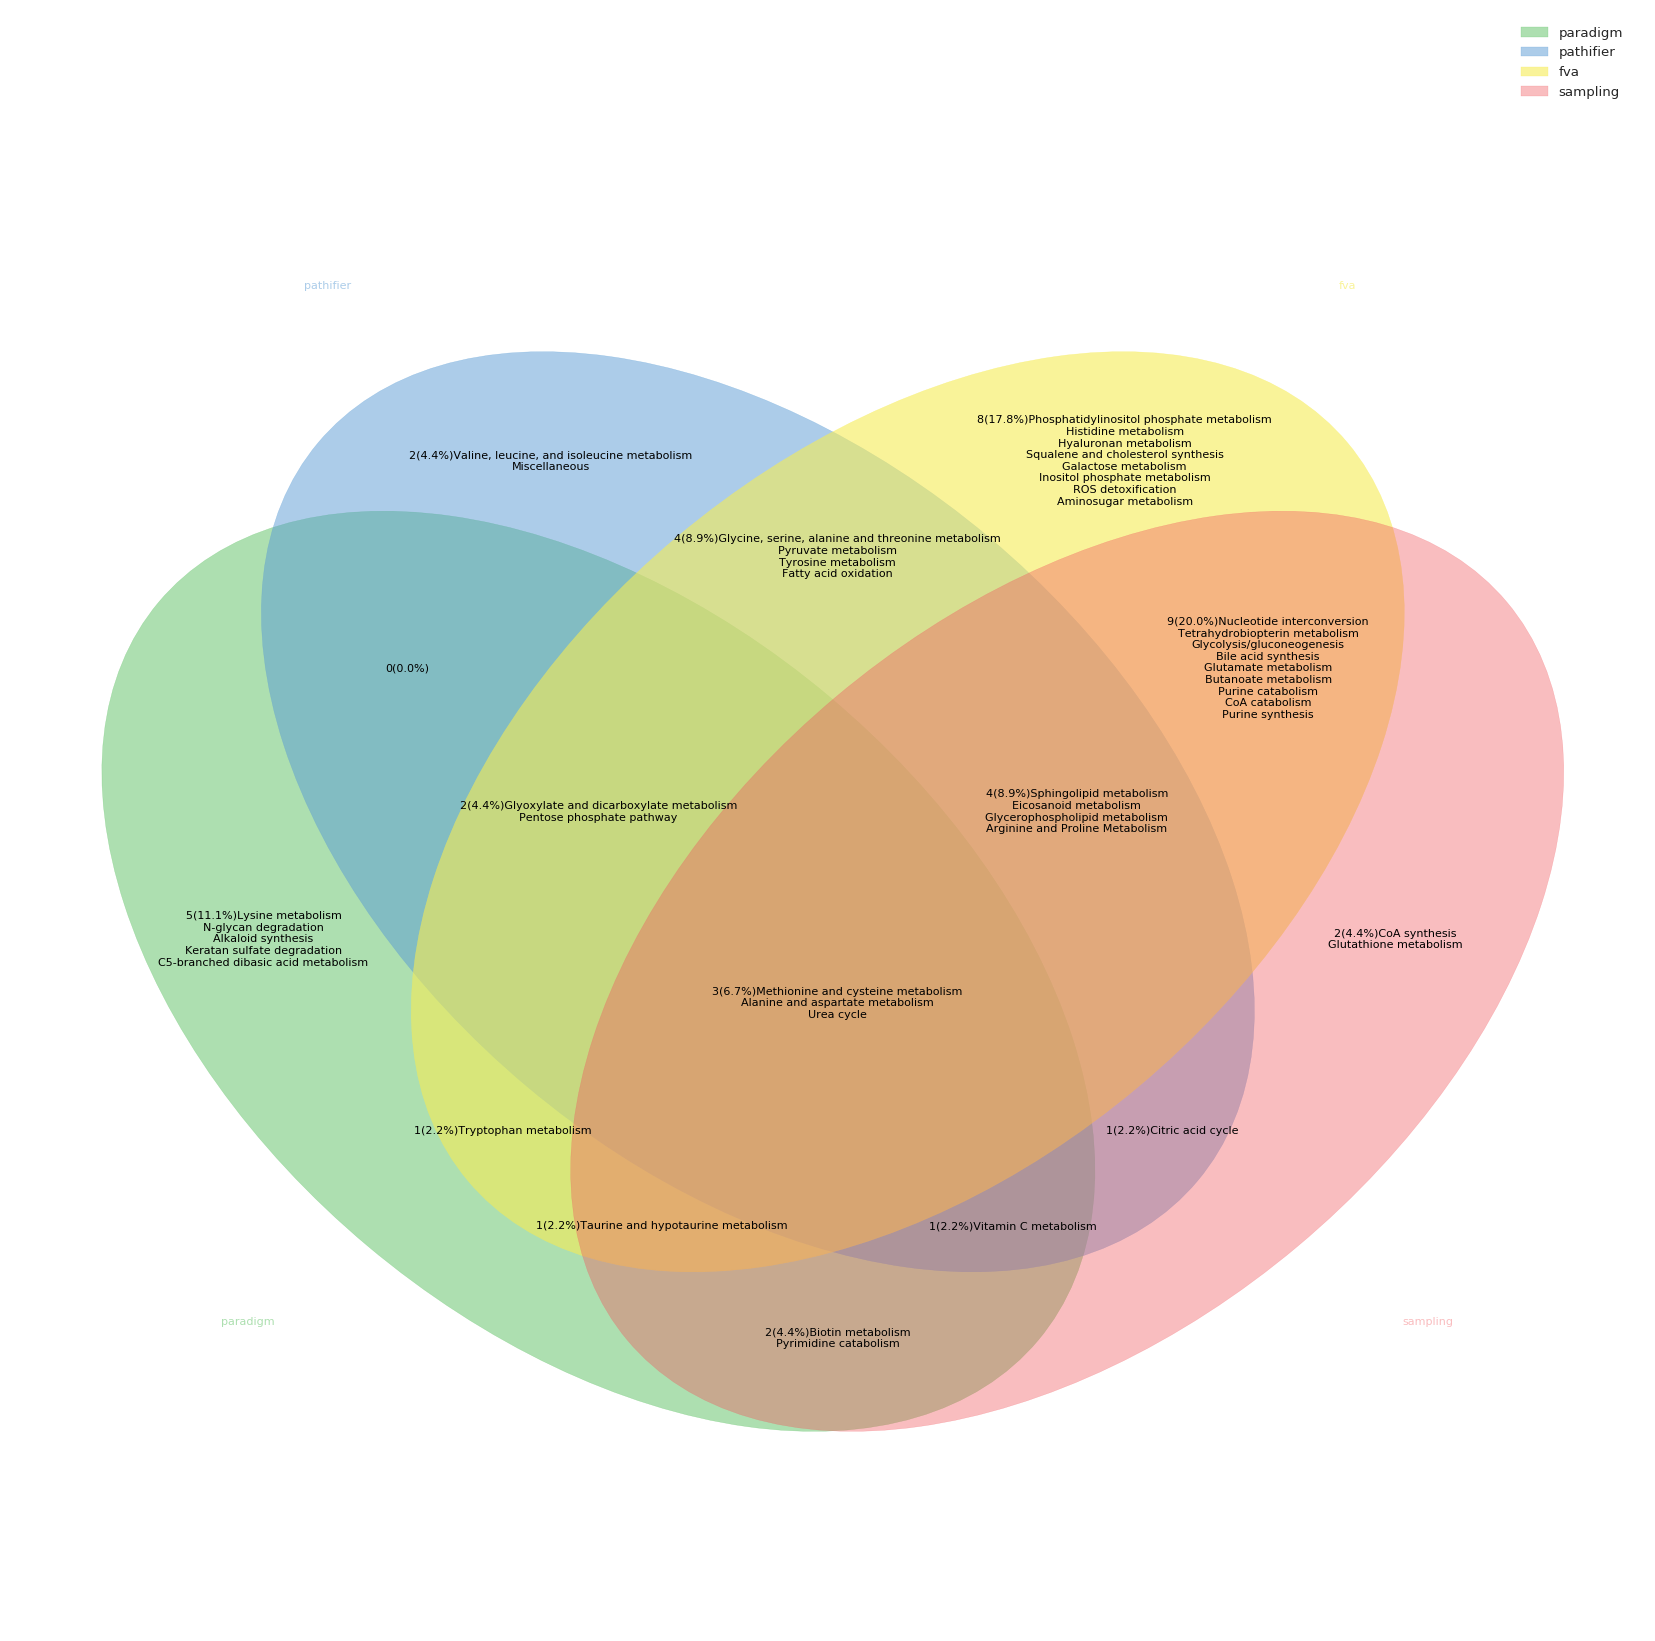

In [20]:
%matplotlib inline
import venn

labels = venn.get_labels([
    paradigm_pathways, 
    pathifier_pathway, 
    metabolitics_fva, 
    metabolitics_sampling], fill=['number', 'percent', 'text'])
fig, ax = venn.venn4(labels, 
                     names=['paradigm', 'pathifier', 'fva', 'sampling'], 
                     fontsize='small', 
                     figsize=(22,22))
fig.show()

### Citric Acid Cycle

https://doi.org/10.1007/s13238-017-0451-1

### Vitamin C

https://dx.doi.org/10.1038%2Fsrep13896

### Biotin Metabolisim

https://doi.org/10.1016/j.ijpharm.2012.10.047

### Coa syntesis